In [24]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Profiling library
!pip install -U ydata-profiling
from ydata_profiling import ProfileReport

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from scipy.stats import skew


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cpu


In [27]:
training_path = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train.csv"
label_path = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train_labels.csv"
df_X = pd.read_csv(training_path)
df_Y = pd.read_csv(label_path)

df_X =pd.merge(df_X, df_Y[['sample_index', 'label']], on='sample_index', how='inner')


## **BEFORE**

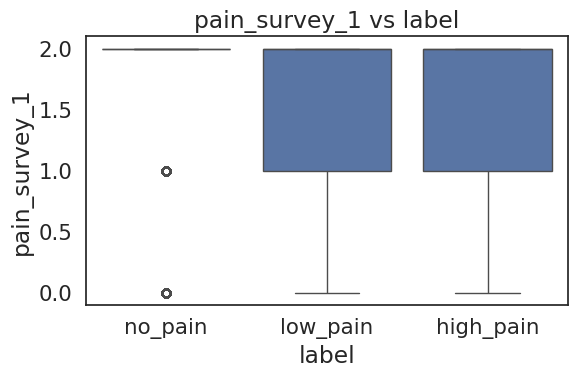

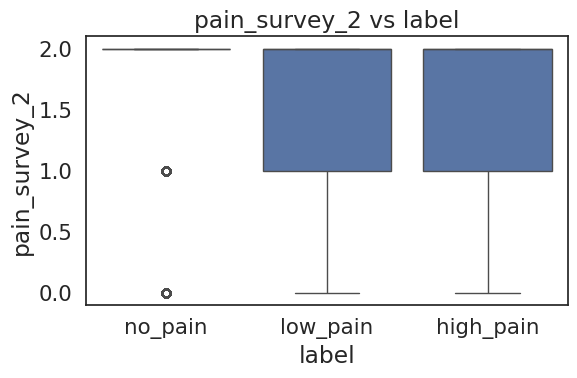

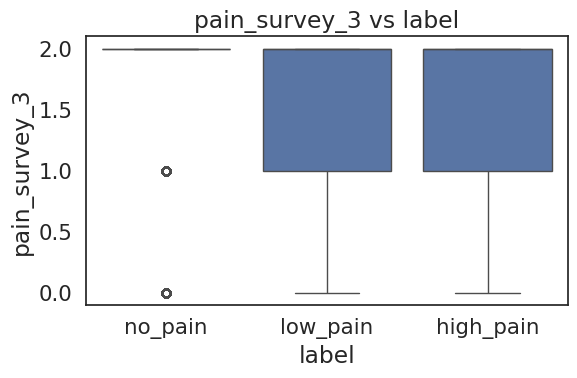

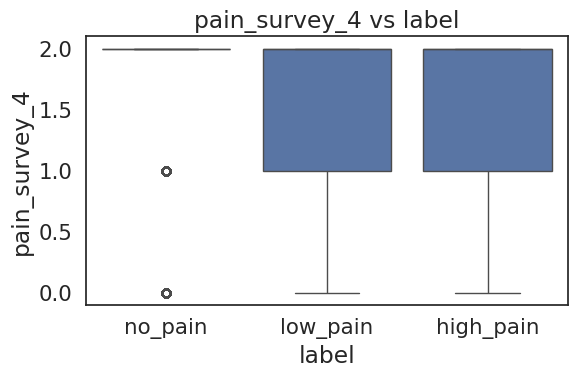

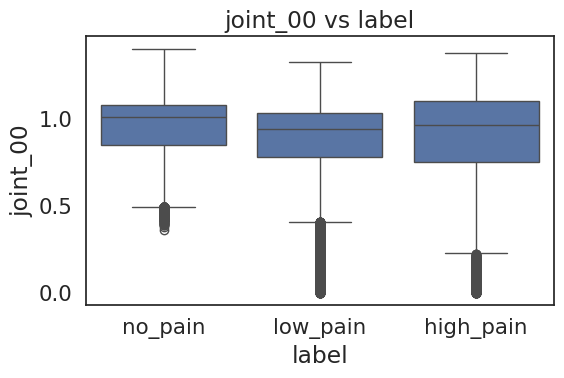

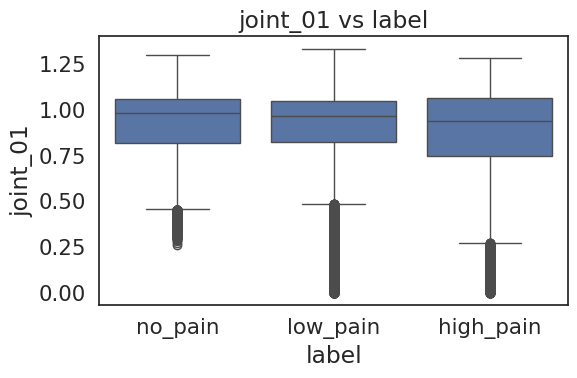

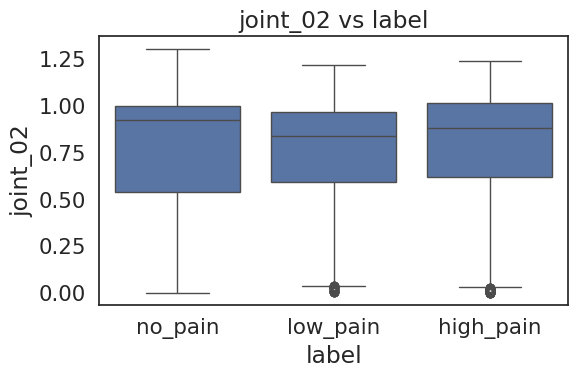

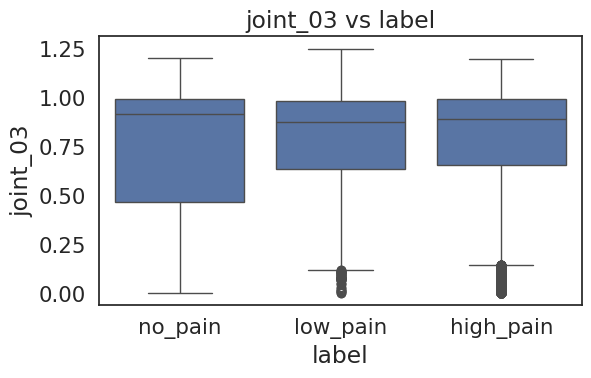

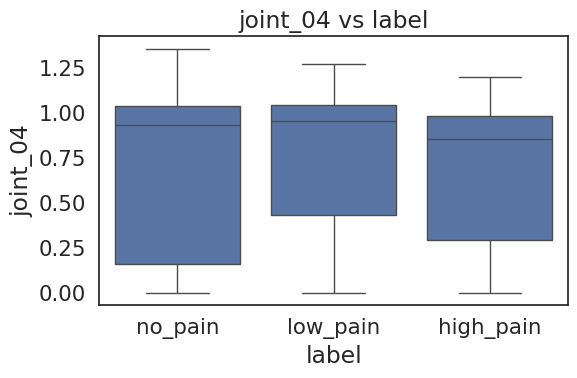

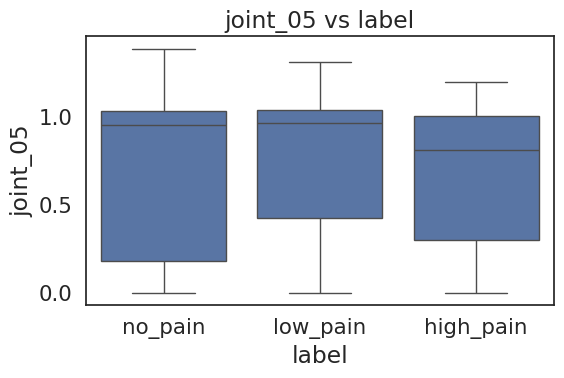

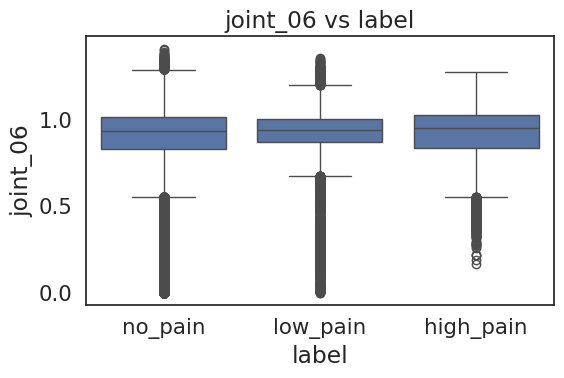

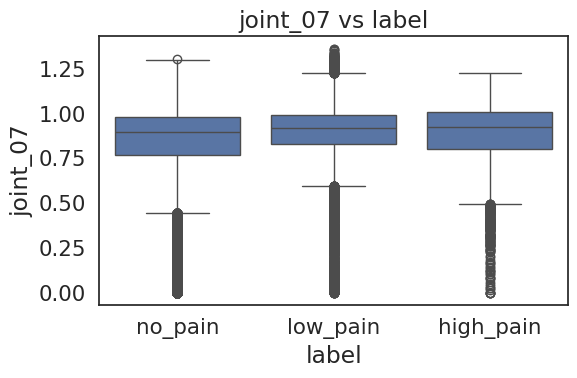

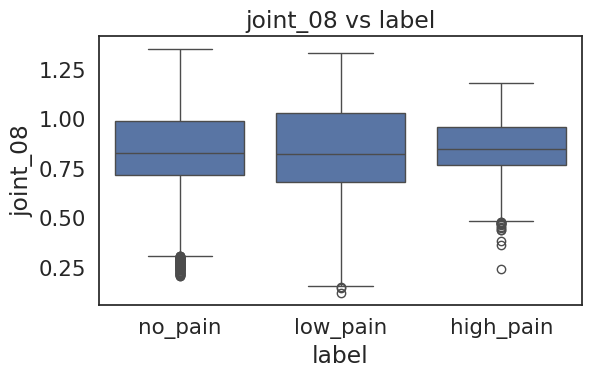

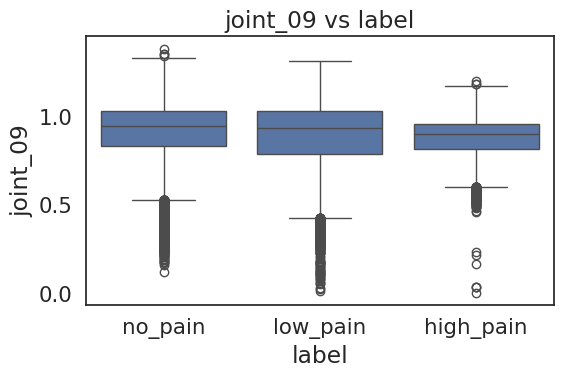

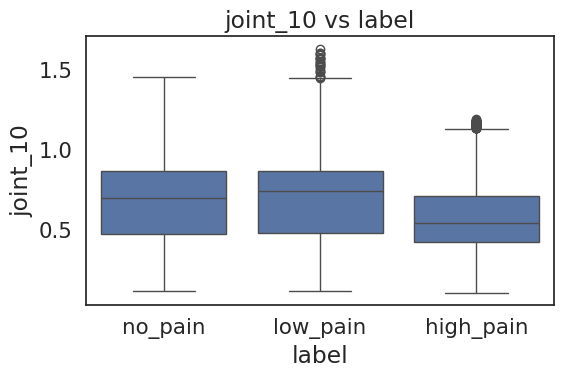

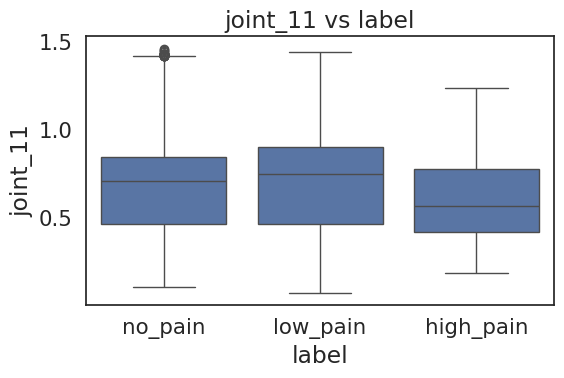

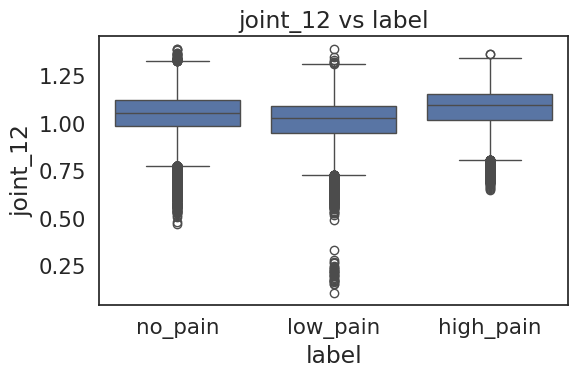

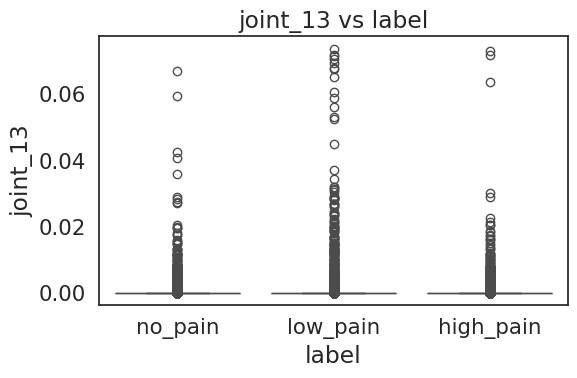

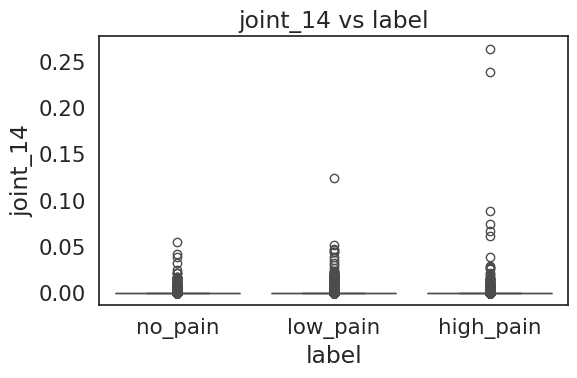

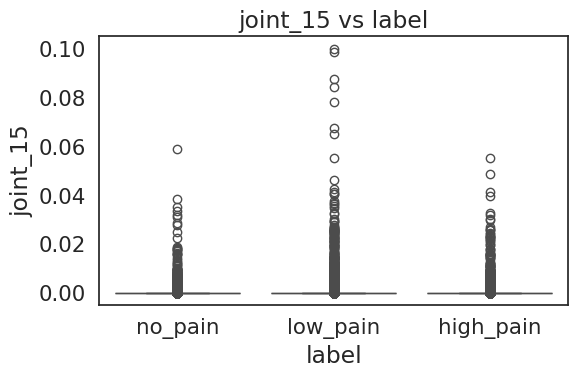

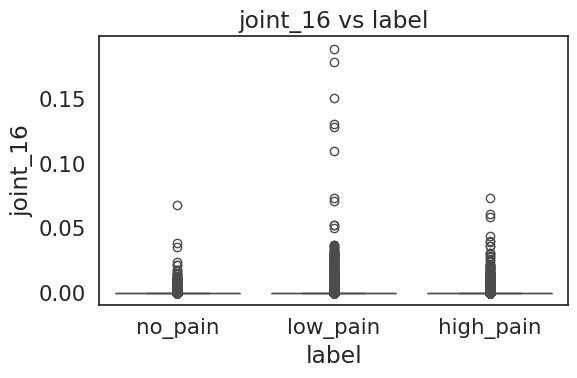

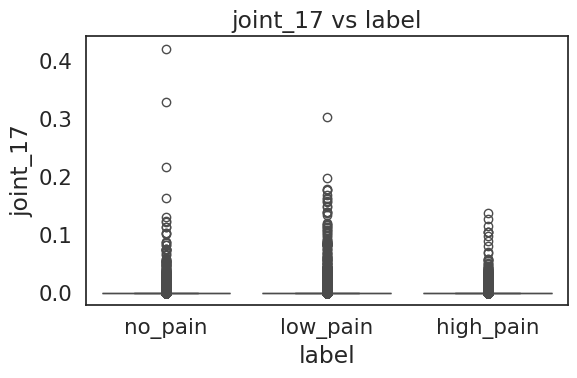

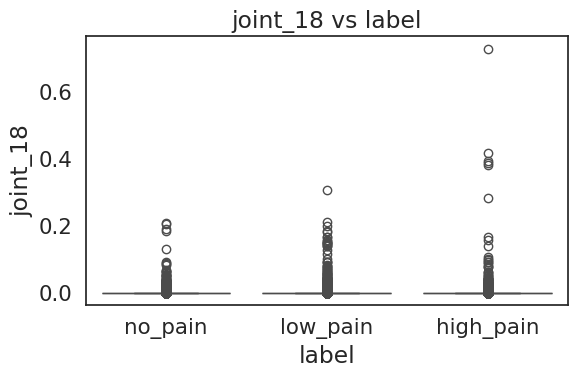

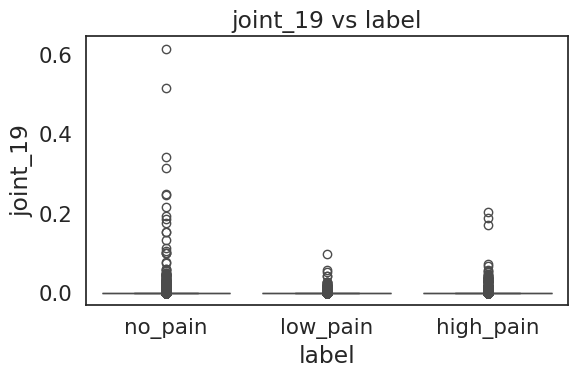

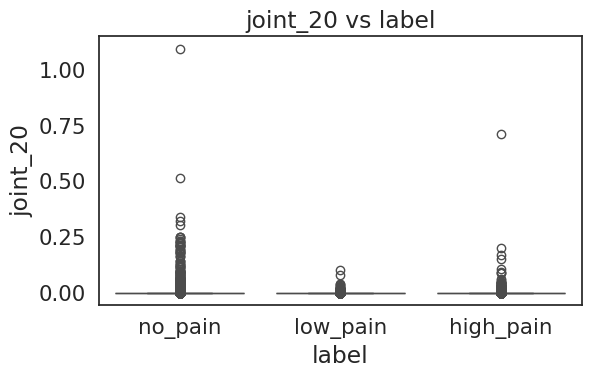

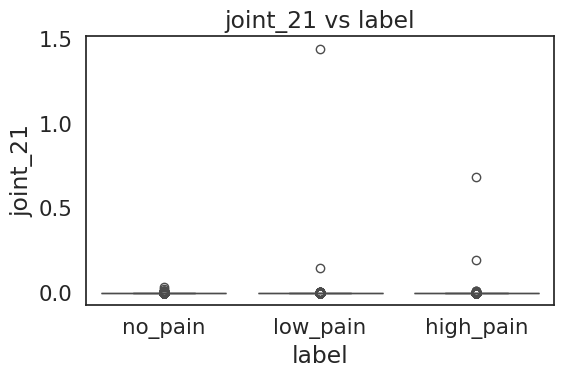

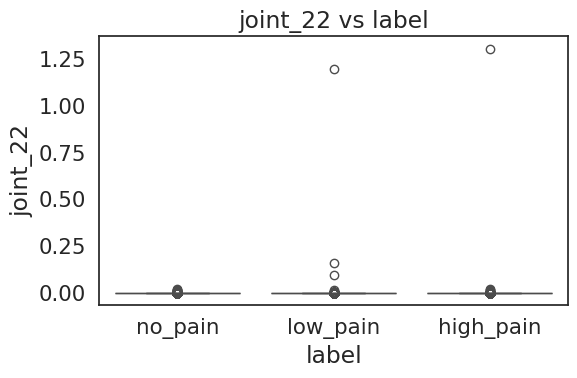

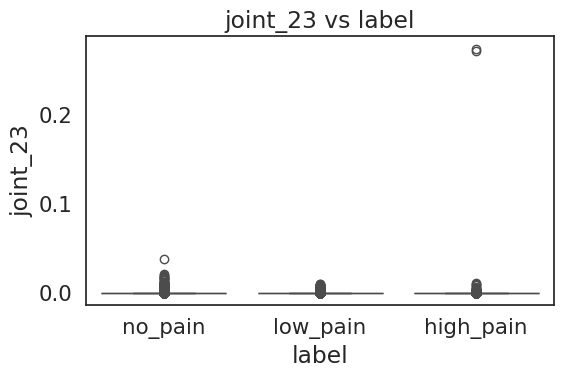

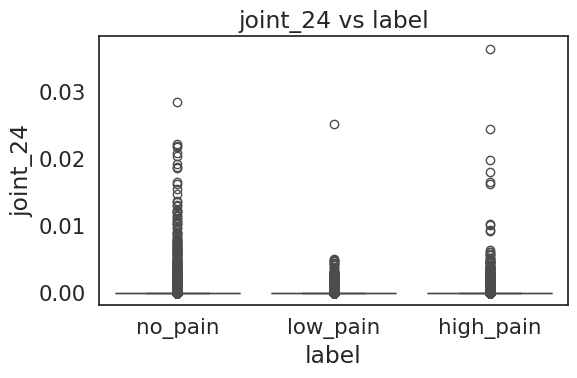

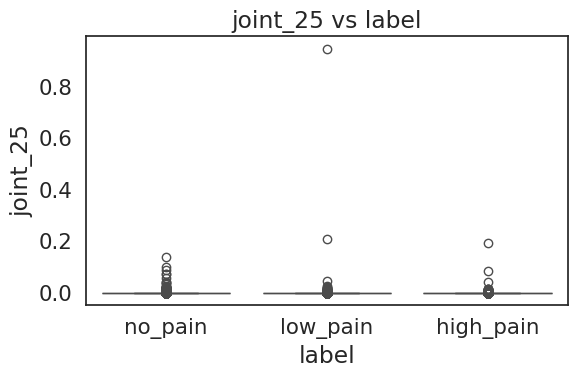

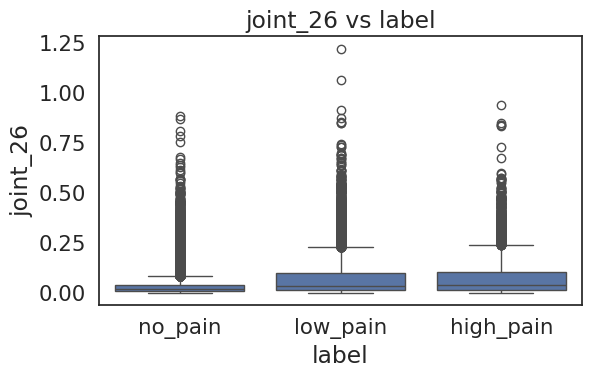

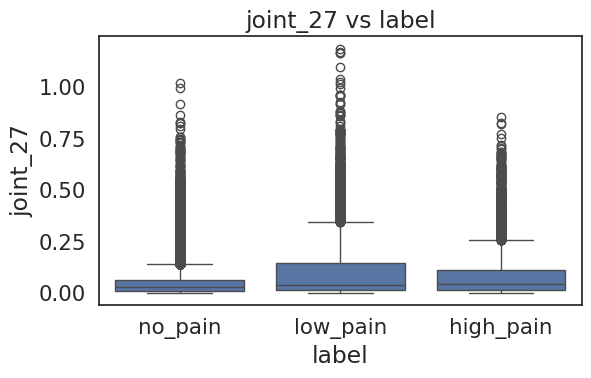

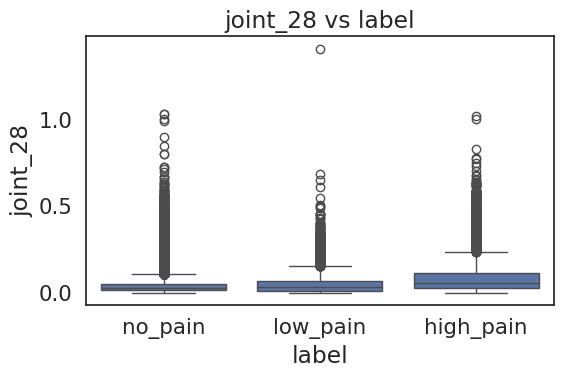

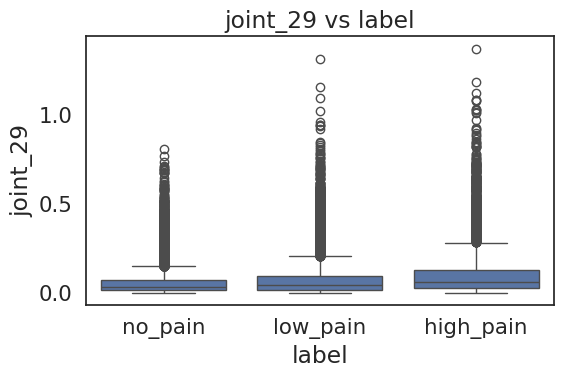

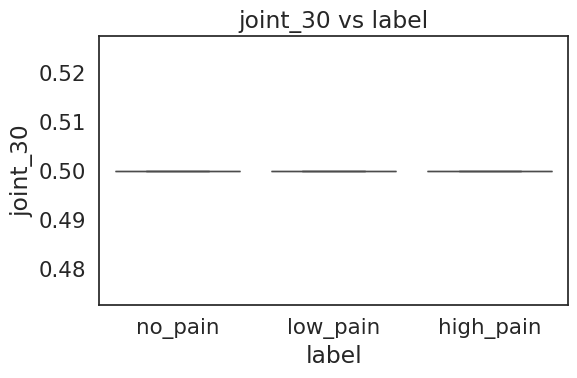

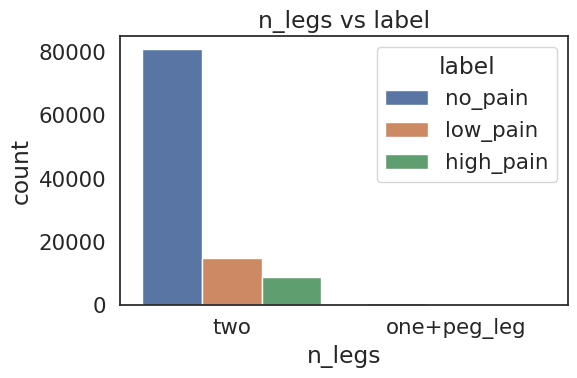

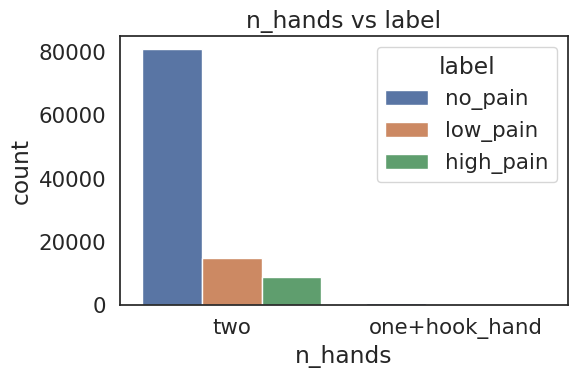

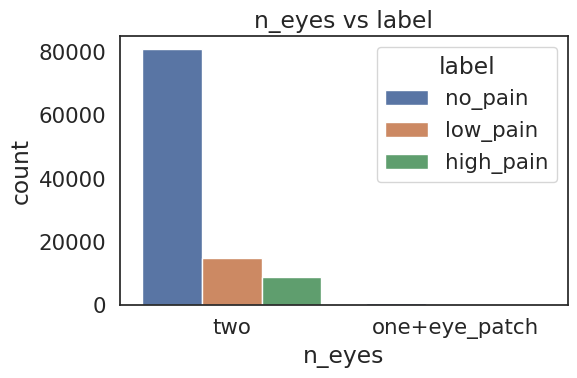

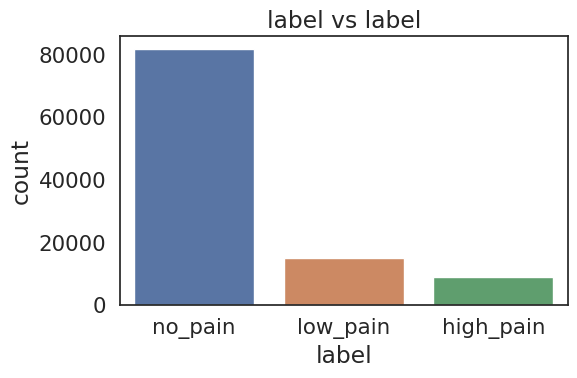

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df_X
# -----------------------------
# Definizione label e features
# -----------------------------
label_col = 'label'  # sostituisci con il nome effettivo della colonna label
features = [col for col in df.columns if col not in [label_col, "sample_index", "time"]]


# Controllo tipi colonne
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
numerical_cols   = [col for col in features if col not in categorical_cols]

# -----------------------------
# Plot per feature numeriche
# -----------------------------
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=label_col, y=col, data=df)
    plt.title(f'{col} vs {label_col}')
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plot per feature categoriche
# -----------------------------
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue=label_col, data=df)
    plt.title(f'{col} vs {label_col}')
    plt.tight_layout()
    plt.show()


## **NORM**

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.covariance import MinCovDet

df_train = df_X




# -----------------------------
# 2️⃣ Feature engineering iniziale
# -----------------------------
# Unifica arti
df_train['n_limbs'] = df_train['n_legs'].apply(lambda x: 2 if x == 'two' else 1)

# Droppa le colonne duplicate o costanti
drop_cols = ['n_legs', 'n_hands', 'n_eyes', 'joint_30']
for df in [df_train]:
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

# -----------------------------
# 3️⃣ Identifica le colonne numeriche
# -----------------------------
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
num_cols = joint_cols


# -----------------------------
# 4️⃣ Gestione zero-inflated features
# -----------------------------
# Crea colonne binarie “is_active” per feature con molti zeri
def add_zero_indicators(df, cols, zero_thresh=0.1):
    for col in cols:
        pct_zero = (df[col] == 0).mean()
        if pct_zero > zero_thresh:
            df[col + '_is_active'] = (df[col] > 0).astype(int)
    return df

for d in [df_train]:
    d = add_zero_indicators(d, joint_cols)

# -----------------------------
# 5️⃣ Rilevamento e clipping outlier (Robust Mahalanobis)
# -----------------------------
def robust_clip_mahalanobis(df, cols, alpha=0.01):
    X = df[cols].values
    mcd = MinCovDet().fit(X)
    mean_robust = mcd.location_
    cov_inv = np.linalg.pinv(mcd.covariance_)
    diff = X - mean_robust
    md = np.sqrt(np.sum(diff @ cov_inv * diff, axis=1))
    threshold = np.sqrt(np.quantile(np.random.chisquare(df=len(cols), size=100000), 1 - alpha))
    mask = md > threshold
    if mask.any():
        factor = threshold / md[mask]
        X[mask] = mean_robust + (X[mask] - mean_robust) * factor[:, None]
    df[cols] = X
    return df

# Applica solo alle colonne high-skew (joint_13-29)
joint_high = [f'joint_{i:02d}' for i in range(13,30) if f'joint_{i:02d}' in df_train.columns]
df_train = robust_clip_mahalanobis(df_train, joint_high)

# -----------------------------
# 6️⃣ Trasformazione anti-skew (Yeo-Johnson)
# -----------------------------
pt = PowerTransformer(method='yeo-johnson')
df_train[joint_cols] = pt.fit_transform(df_train[joint_cols])

# -----------------------------
# 7️⃣ Scaling coerente (Min-Max)
# -----------------------------
scaler = MinMaxScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

# -----------------------------
# 8️⃣ Pulizia finale
# -----------------------------
# Sostituisci eventuali NaN (es. dopo log/PowerTransform)
for d in [df_train]:
    d.fillna(0, inplace=True)

print("Valori unici in label:", df_train['label'].unique())


Valori unici in label: ['no_pain' 'low_pain' 'high_pain']


# **AFTER**

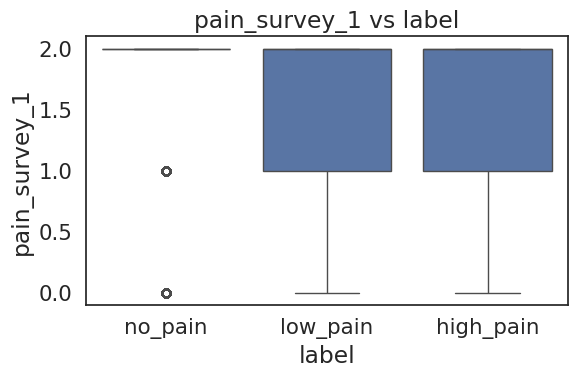

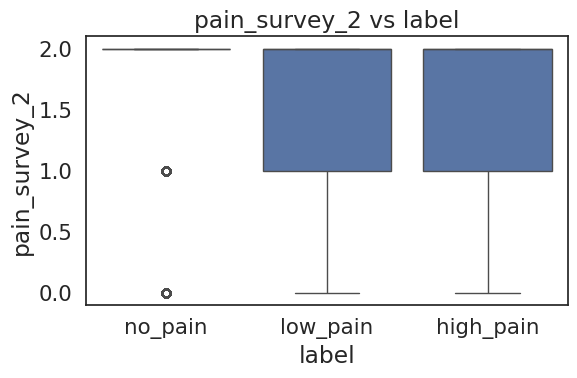

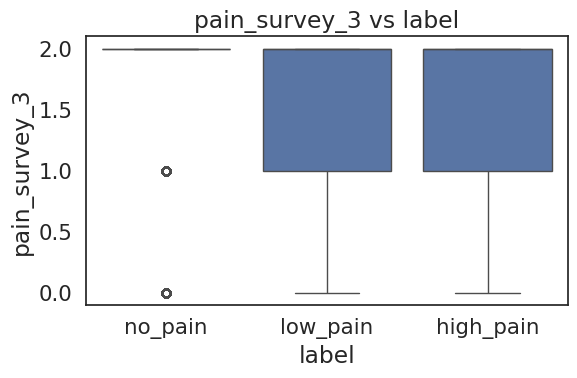

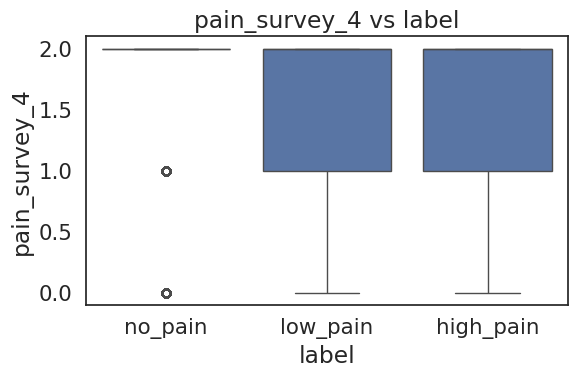

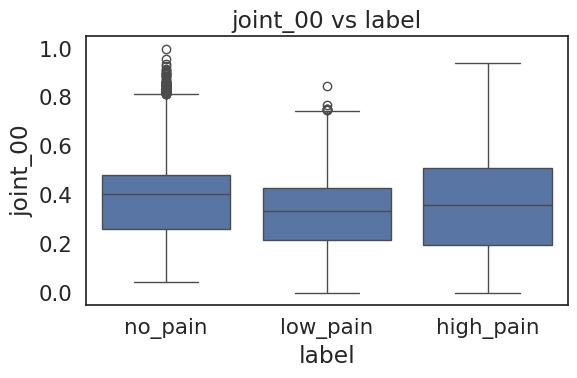

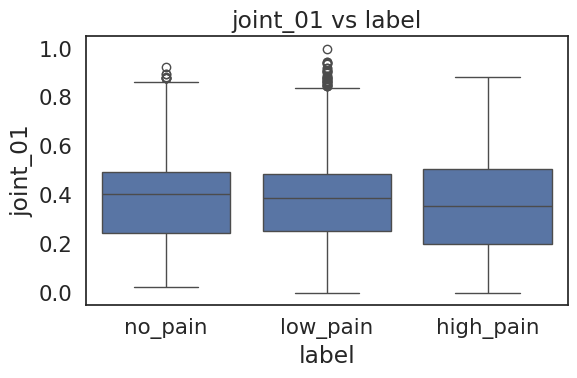

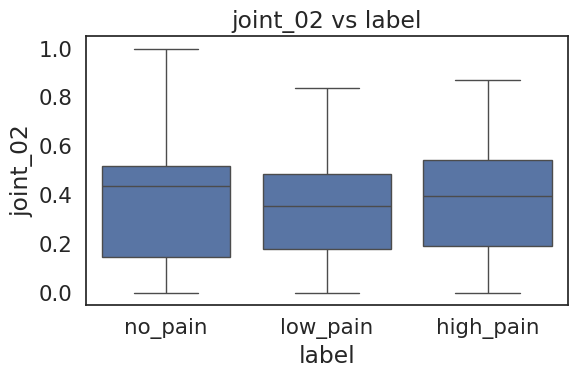

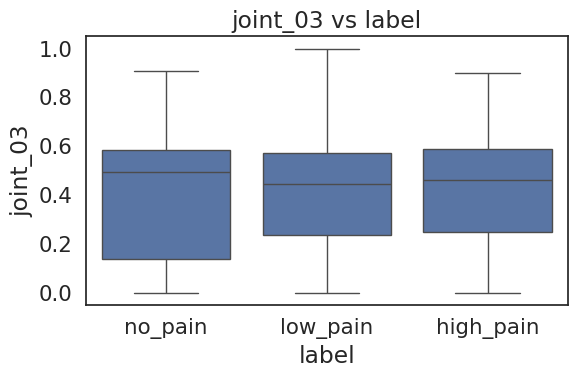

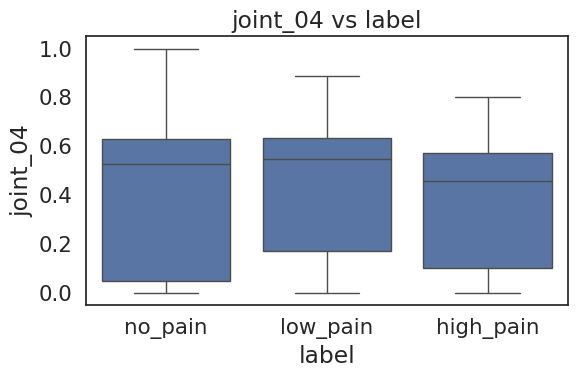

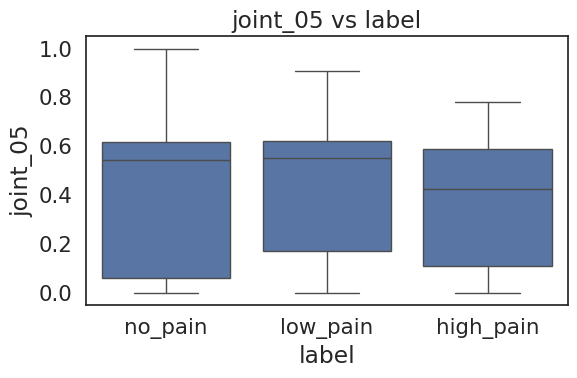

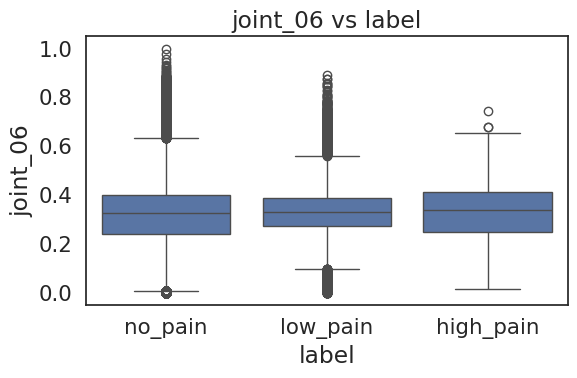

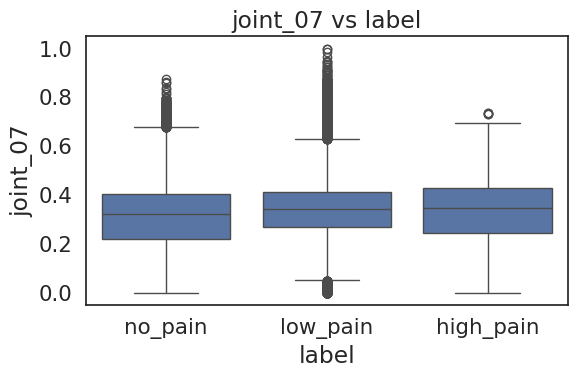

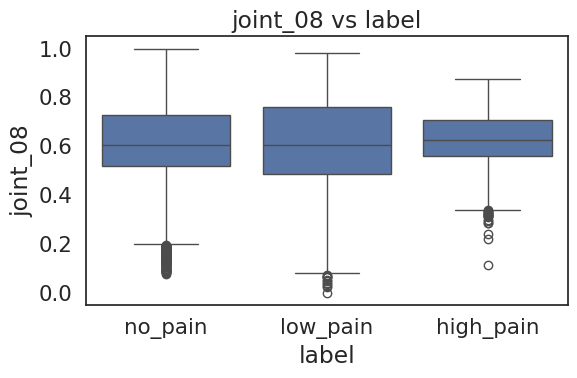

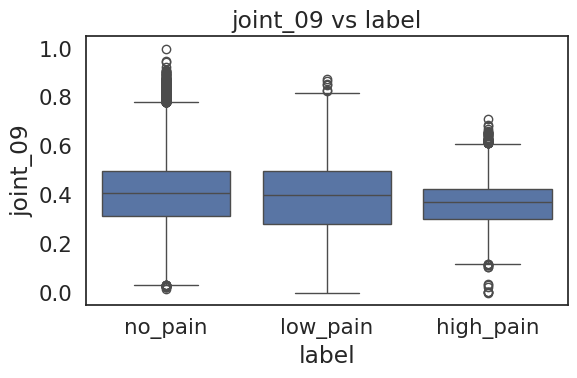

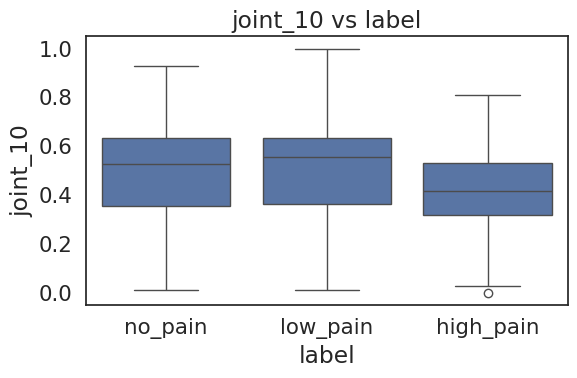

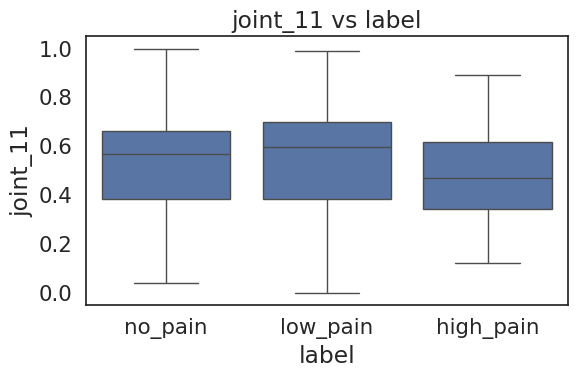

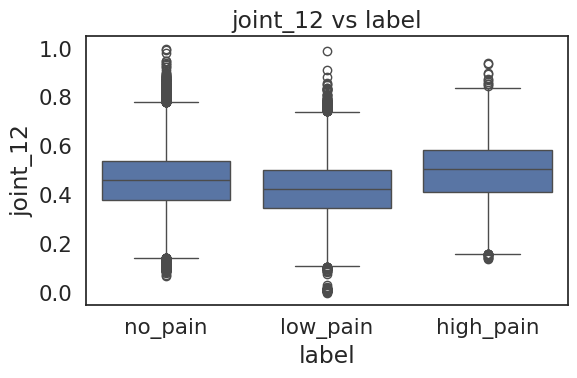

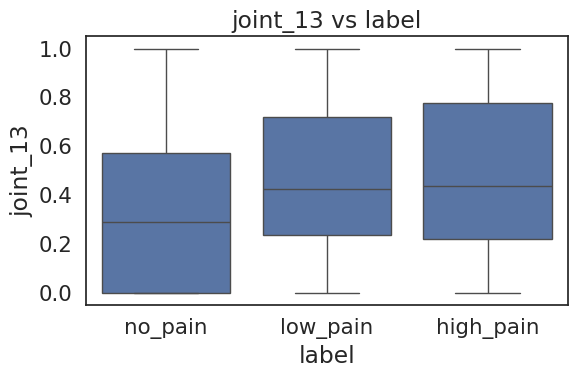

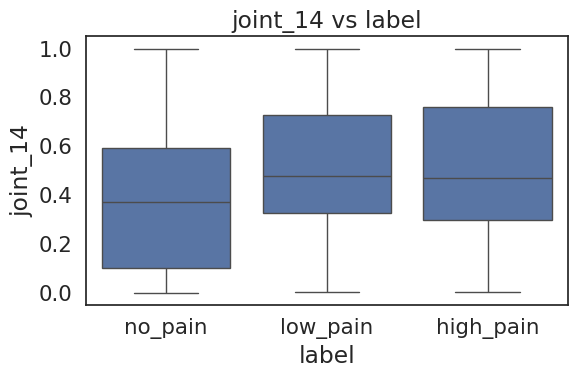

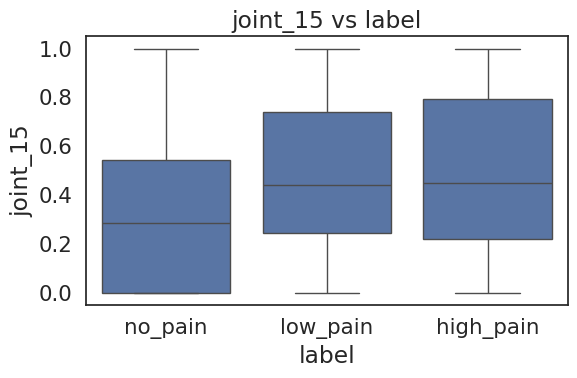

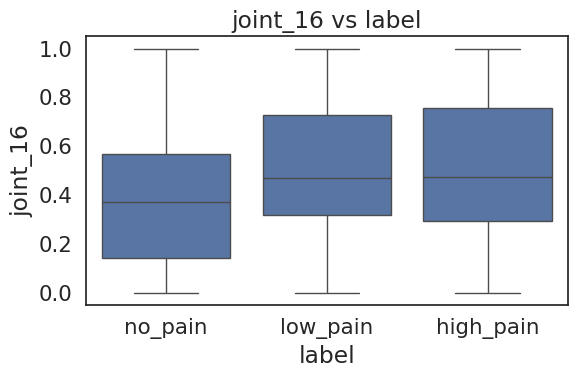

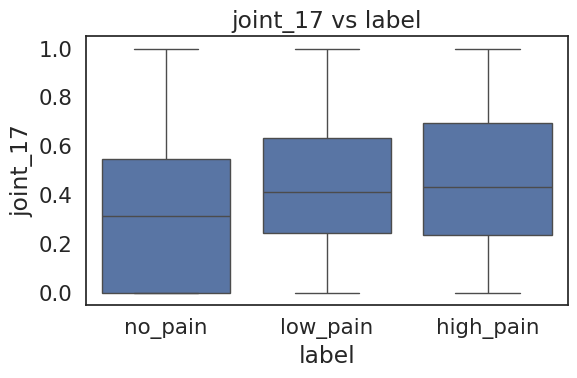

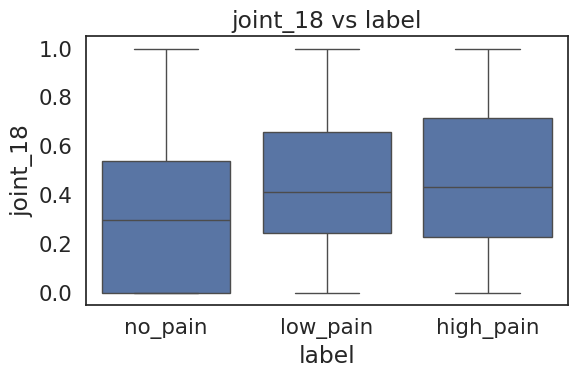

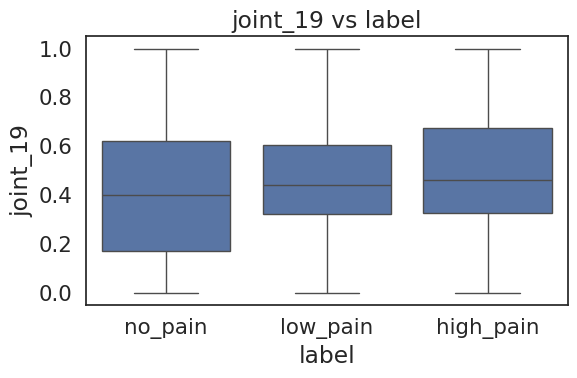

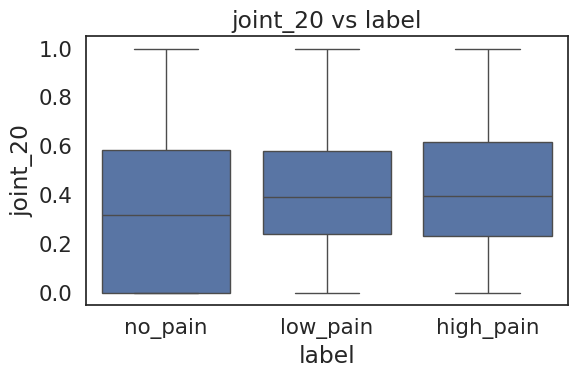

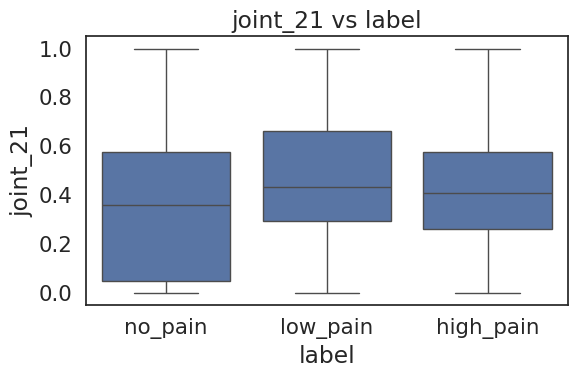

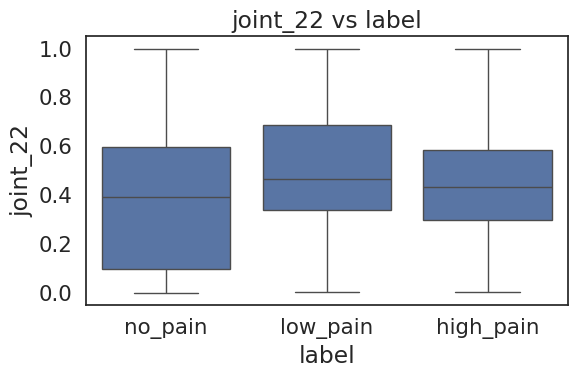

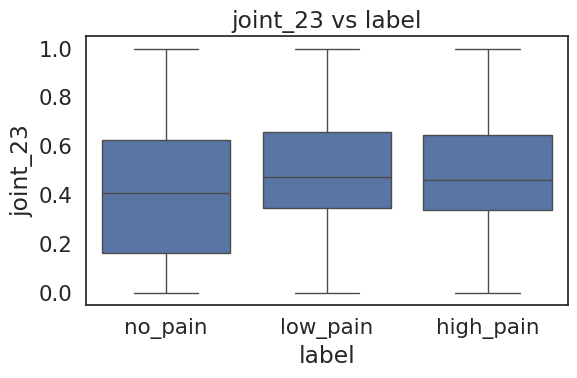

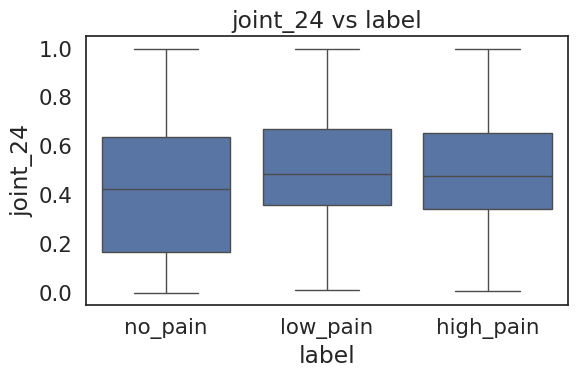

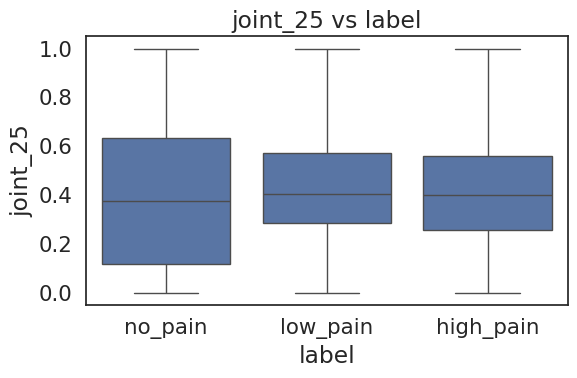

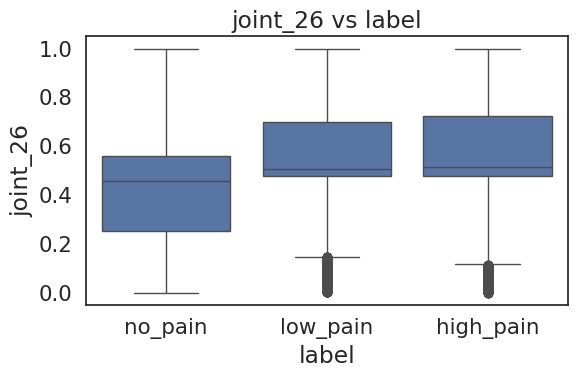

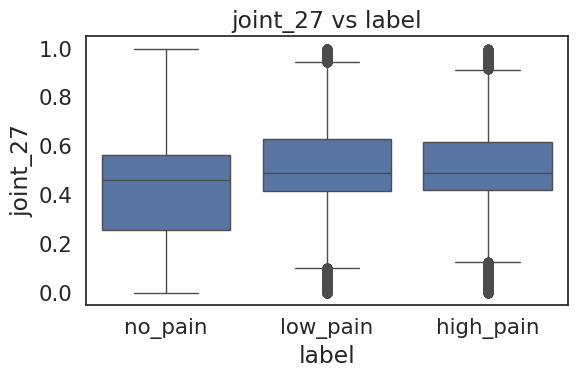

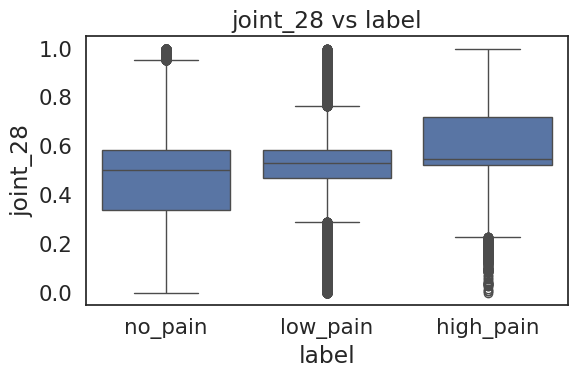

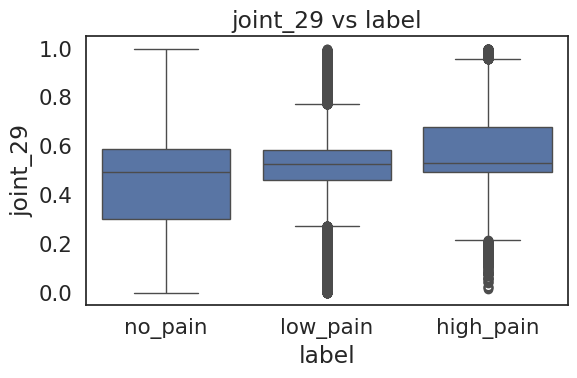

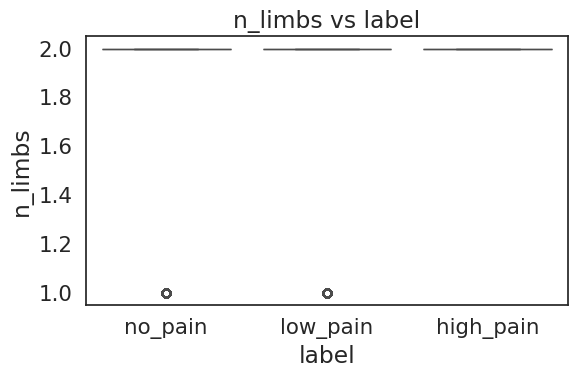

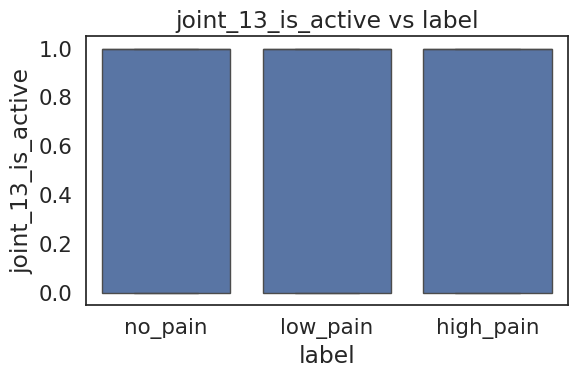

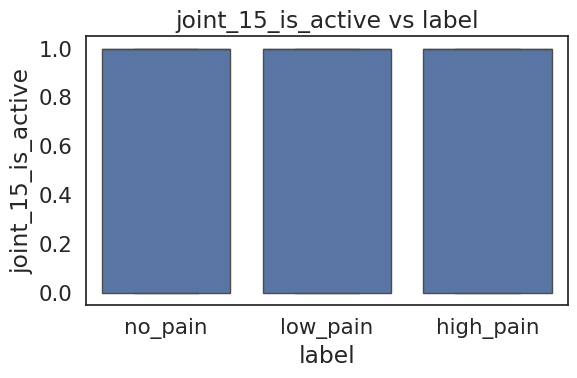

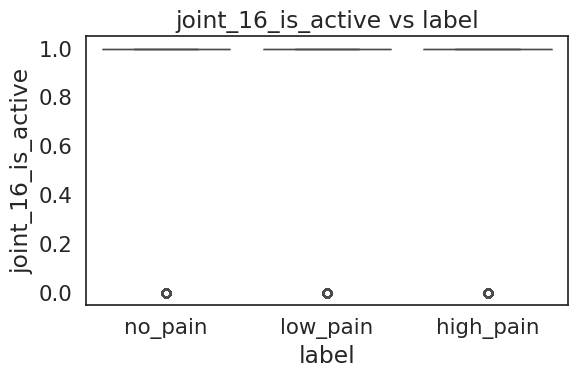

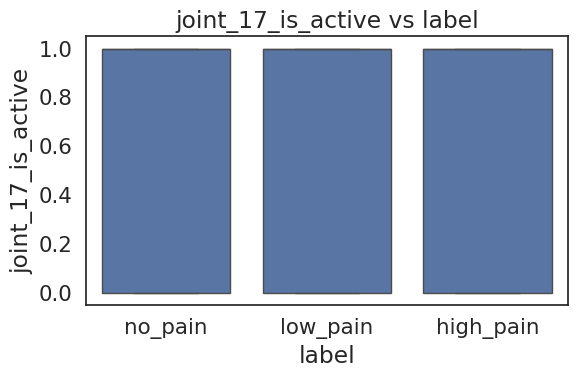

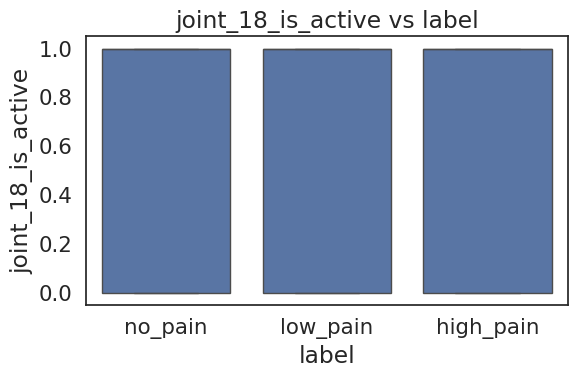

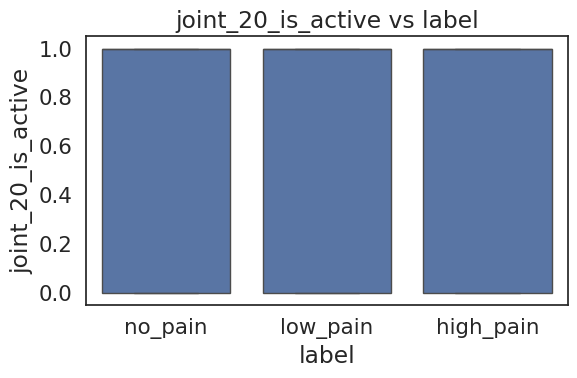

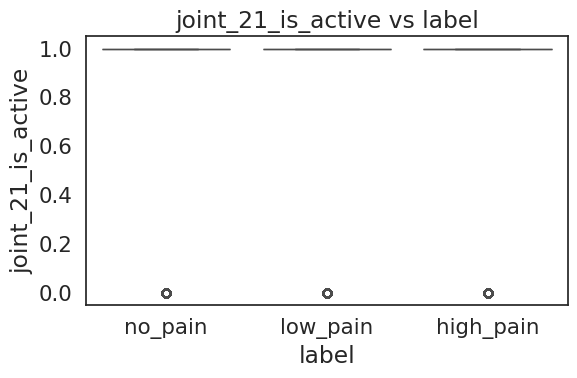

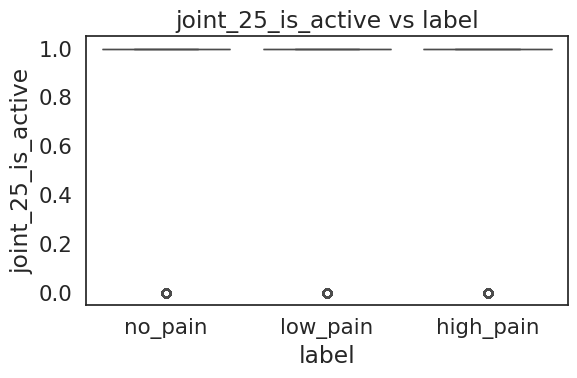

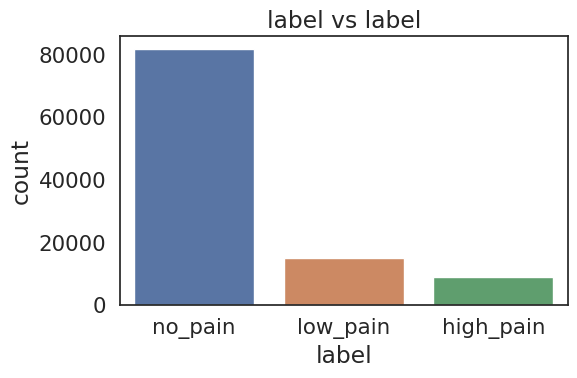

In [31]:
df = df_train
# -----------------------------
# Definizione label e features
# -----------------------------
label_col = 'label'  # sostituisci con il nome effettivo della colonna label
features = [col for col in df.columns if col not in [label_col, "sample_index", "time"]]


# Controllo tipi colonne
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
numerical_cols   = [col for col in features if col not in categorical_cols]

# -----------------------------
# Plot per feature numeriche
# -----------------------------
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=label_col, y=col, data=df)
    plt.title(f'{col} vs {label_col}')
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plot per feature categoriche
# -----------------------------
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue=label_col, data=df)
    plt.title(f'{col} vs {label_col}')
    plt.tight_layout()
    plt.show()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 41/41 [00:06<00:00,  6.07it/s]
Exception ignored in: <function _xla_gc_callback at 0x78bbaa62aac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


KeyboardInterrupt: 

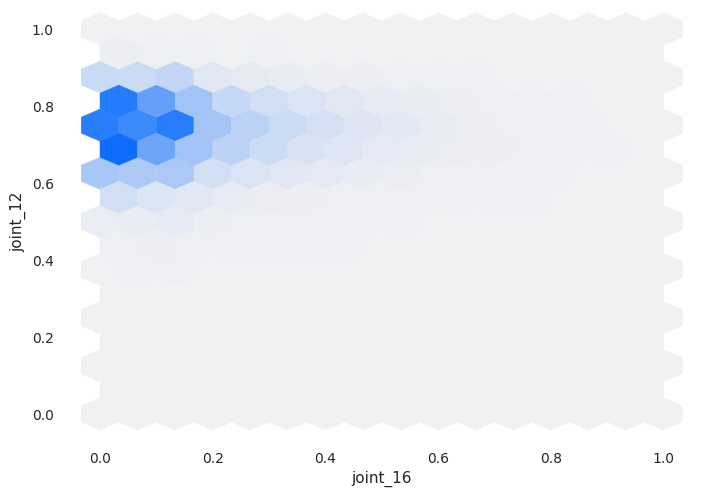

In [18]:
data_profile = ProfileReport(df_train, title="Pandas Profiling Report")
data_profile